In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd #data reading
!pip install peakutils
import peakutils as peakutils #peakutils.baseline
import math
import csv

In [3]:
Mn_tot,PDI,Mw_mono = 37800,1.8,229.28
Mw_initiator, Mw_protein, degree_of_initiator = 220,25367,5
#5=3*2-1 or you can adjust yourself
Number_polymer = 10000 #if you want less noisy/fewer knots for prediction distribution and unless it is less than 100 it will not influence value results
step = 2 #directly relevant to calculation load, fewer than 20 is practical, 2 is fastest, no need to go up
Smoothfactor = 1 #if you don't like knots at all, slice calculation interval to generate the combined
min, max = 2000,4e5
min2, max2 = min+ Mw_protein, Mw_protein+max*degree_of_initiator
Mw_new = 10**(np.linspace(np.log10(min), np.log10(max), Number_polymer))
# Mw_new = np.linspace(min, max, Number_polymer)

In [4]:
with open('/content/drive/MyDrive/Master Research/GPC Calculation Model/data/All data/L-3 MALDI.csv', encoding="utf-8") as f:
    #pass
    data = np.loadtxt(f, delimiter = ",",skiprows=1)
    x2 = data[:, 0]
    y2 = data[:, 1]
base = peakutils.baseline(np.asarray(y2),deg = 1, max_it = 100000, tol = .0001)#deg, max_it, tol can be customized
y2_baselined = y2 - base
y2 = y2_baselined/np.sum(y2_baselined)

In [5]:
a,d = Mw_protein, Mw_initiator

x = x2
y=y2
x = np.array(x)
y = np.array(y)

sample_step_x_p = []
sample_step_y_p = []

Length = d
for i in range(int(a), int(a+degree_of_initiator*d), Length):
    begin = i
    end = i + Length
    candidate = []
    candidate = np.array(candidate)
    candidate = candidate.astype('int64')
    for j in range(0,x.size):
        if (x[j] <= end) and (x[j] >= begin):
            #print(x[j])
            candidate = np.append(candidate, int(j))
    #print(candidate)
    if(candidate.size == 0):
        continue
    x_sample = x[candidate]
    y_sample = y[candidate]
    x_ave = np.mean(x_sample)
    y_ave = np.mean(y_sample)
    sample_step_x_p = np.append(sample_step_x_p, x_ave)
    sample_step_y_p = np.append(sample_step_y_p, y_ave)
sample_step_x_p=sample_step_x_p
sample_step_y_p=sample_step_y_p/np.sum(sample_step_y_p)

In [6]:
sample_step_y_p

array([0.14000456, 0.19626662, 0.25503435, 0.24078942, 0.16790505])

In [7]:
#log distribution for stepwise calculation
Mw_tot = Mn_tot*PDI
M0 = (Mn_tot*Mw_tot)**0.5
sigma2 = np.sqrt(np.log(Mw_tot/Mn_tot))
def LN(x, x0, sigma):
    return 1/sigma/np.sqrt(2*np.pi)/x* np.exp(-1/2/(sigma**2)*((np.log(((x/x0)))**2)))

In [8]:
x1_2_new=Mw_new
y1_2_new= LN(Mw_new,M0,sigma2)/np.log10(np.e)*Mw_new###attention!!!

In [9]:
x1_2 = [x1_2_new[i:i+step] for i in range(0,len(x1_2_new),step)]
y1_2 = [y1_2_new[i:i+step] for i in range(0,len(x1_2_new),step)]

In [10]:
N__1, N__2, N__3, N__4, N__5 = [], [], [], [], []
P__1, P__2, P__3, P__4, P__5 = [], [], [], [], []
N_2=[]
P_2=[]

In [11]:
for ii in range(len(x1_2)-1):
    x1 = x1_2[ii]
    y1 = y1_2[ii]
    N1, N2, N3, N4, N5 = [], [], [], [], []
    P1, P2, P3, P4, P5 = [], [], [], [], []
    for i in range(step):
        N1.append(x1[i] + a)
        P1.append(y1[i] * sample_step_y_p[0])
    N__1.extend(N1)
    P__1.extend(P1)
    for i in range(step):
        for j in range(step):
            N2.append(N1[i] + x1[j])
            P2.append((P1[i] + y1[j]) * sample_step_y_p[1])
    N__2.extend(N2)
    P__2.extend(P2)
    for i in range(step ** 2):
        for j in range(step):
            N3.append(N2[i] + x1[j])
            P3.append((P2[i] + y1[j]) * sample_step_y_p[2])
    N__3.extend(N3)
    P__3.extend(P3)
    for i in range(step ** 3):
        for j in range(step):
            N4.append(N3[i] + x1[j])
            P4.append((P3[i] + y1[j]) * sample_step_y_p[3])
    N__4.extend(N4)
    P__4.extend(P4)
    for i in range(step ** 4):
        for j in range(step):
            N5.append(N4[i] + x1[j])
            P5.append((P4[i] + y1[j]) * sample_step_y_p[4])
    N__5.extend(N5)
    P__5.extend(P5)
    
    N_2_proxy = np.concatenate((N1, N2, N3, N4, N5),axis=0)
    P_2_proxy = np.concatenate((P1, P2, P3, P4, P5),axis=0)
    N_2 = np.append(N_2, N_2_proxy)
    P_2 = np.append(P_2, P_2_proxy)


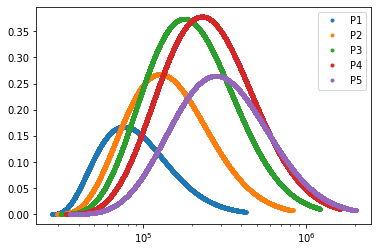

In [12]:
fig, ax = plt.subplots()
ax.semilogx(N__1,P__1,'.')
plt.plot(N__2,P__2,'.')
plt.plot(N__3,P__3,'.')
plt.plot(N__4,P__4,'.')
plt.plot(N__5,P__5,'.')
name=[]
for i in range(degree_of_initiator):
  name.append(f'P{i+1}')
plt.legend(name)

In [13]:
order = np.argsort(N_2)

In [14]:
N22=[]
P22=[]
for i in order:
  N22.append(N_2[i])
  P22.append(P_2[i])


In [15]:
from itertools import groupby
n2=[]
p2=[]
index=[]
for k, g in groupby(N22, key=lambda x: x//(Mw_mono*Smoothfactor)):
  index.append(len(list(g)))
for k, g in groupby(N22, key=lambda x: x//(Mw_mono*Smoothfactor)):
  n2.append(np.mean(list(g)))  
j=0

for i in index:
  s=np.sum(P22[j:j+i])
  j+=i
  p2.append(s)

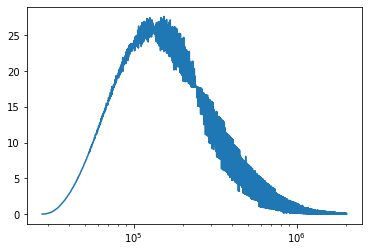

In [16]:
fig, ax = plt.subplots()
ax.semilogx(n2,p2,'-')

In [17]:
x_conjugate = n2
y_conjugate = p2
def predict_verification3(Mw,baselined_intensity):
  ##Module calculation
  sigmaH = 0
  W = []
  M =[]
  H =[]
  sum_Wi_Mi = 0  
  sum_WiMi = 0   

  for x,y in zip(Mw, baselined_intensity):
    if x >= min2 and x <= max2:
      sigmaH += y
      M.append(x)

  for x,y in zip(Mw, baselined_intensity):
    if x >= min2 and x <= max2:
      W.append(y/sigmaH)
      H.append(y)

  for i in range(len(W)):
    sum_Wi_Mi += W[i]/M[i]
    sum_WiMi += W[i]*M[i]


  Mn_tot = 1/(sum_Wi_Mi)
  Mw_tot = sum_WiMi
  PDI = Mw_tot / Mn_tot

  print(f'Predicted Conjugate Mn is {Mn_tot:.1f} Da, Mw is {Mw_tot:.1f} Da, PDI is {PDI:.2f}')
predict_verification3(x_conjugate,y_conjugate)


Predicted Conjugate Mn is 184247.3 Da, Mw is 299285.2 Da, PDI is 1.62


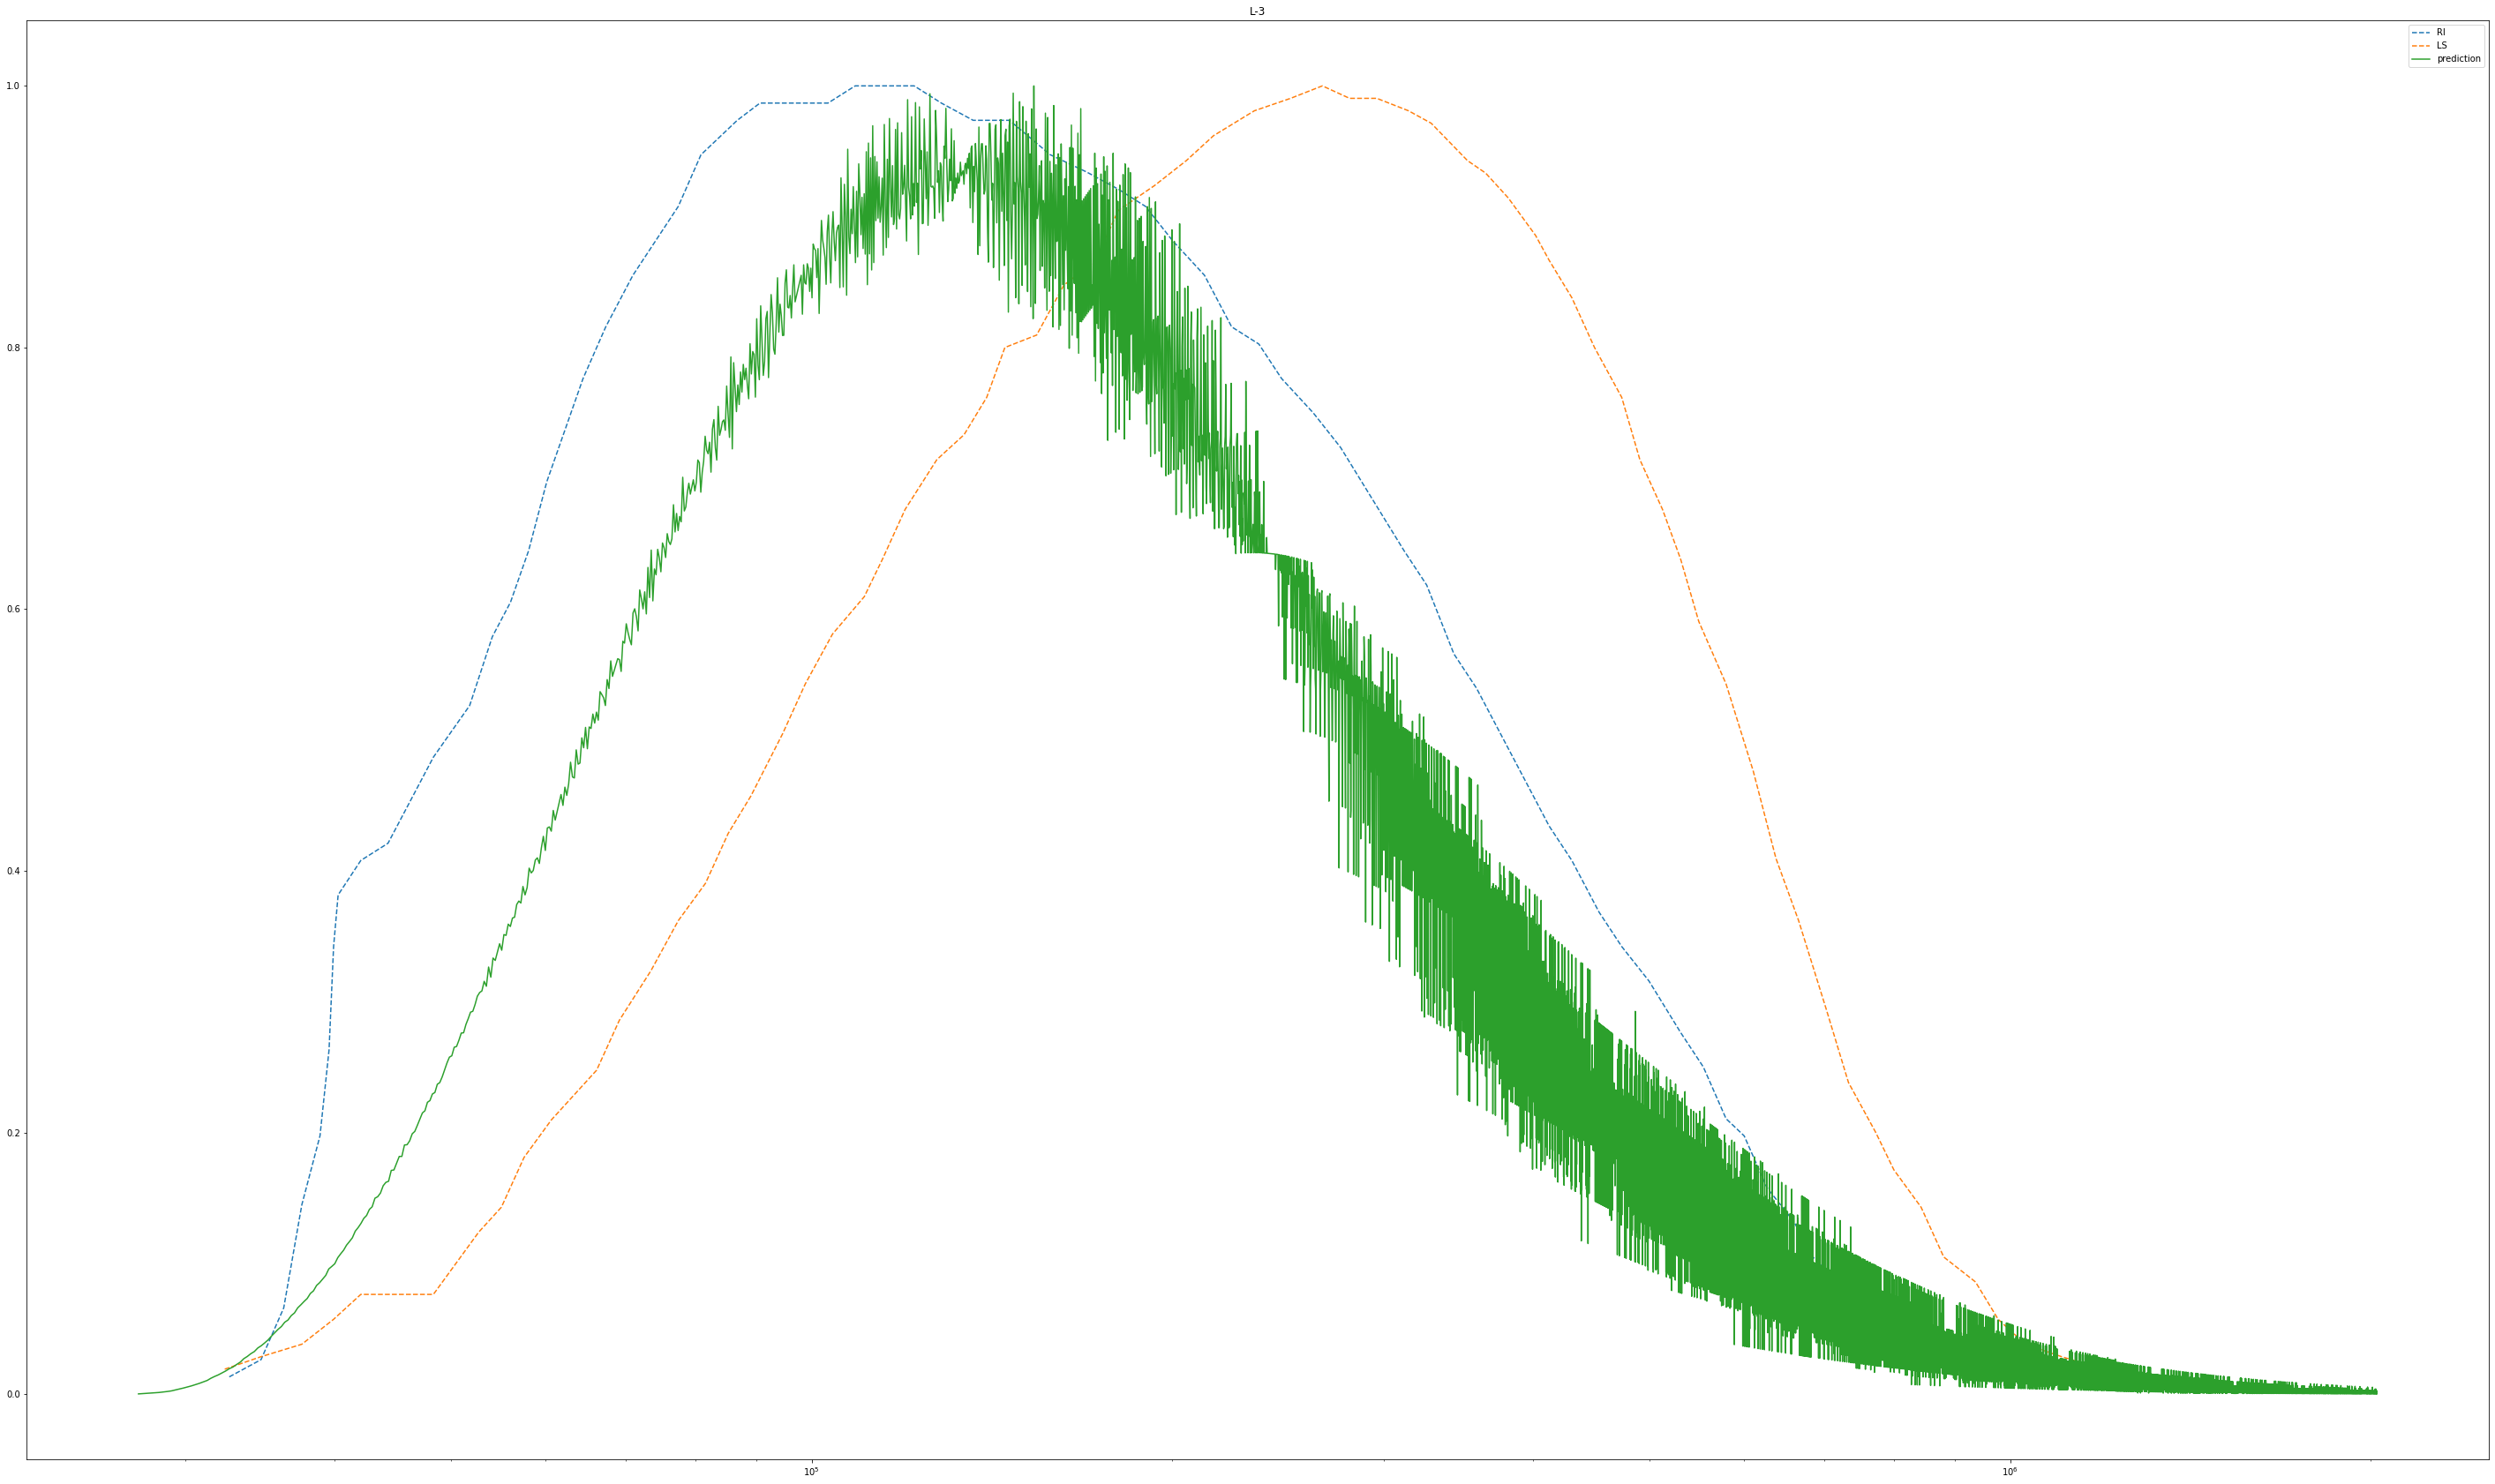

Text(0.5, 1.0, 'L-3 comparison between experimental(dense) and prediction results')

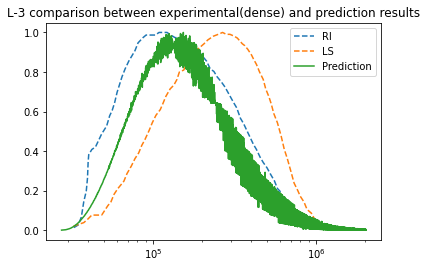

In [18]:
with open('/content/drive/MyDrive/Master Research/GPC Calculation Model/data/All data/L-3 MALS-RI(dense).csv', encoding="utf-8") as f:
    #pass
    data2 = np.loadtxt(f, delimiter = ",")
    m1 = data2[:, 1]
    o1 = data2[:, 2]#[:,2]corresdponds to L-S MALS-MM1; [:,3]corresponds to MM2(chosen)
with open('/content/drive/MyDrive/Master Research/GPC Calculation Model/data/All data/L-3 MALS-LS(dense).csv', encoding="utf-8") as f:
    #pass
    data3 = np.loadtxt(f, delimiter = ",")
    m2 = data3[:, 1]
    o2 = data3[:, 2]   
fig, ax = plt.subplots(figsize=(50, 30))
ax.semilogx(o1,m1/np.max(m1),'--')
plt.semilogx(o2,m2/np.max(m2),'--')
plt.semilogx(n2,p2/np.max(p2),'-')
plt.legend(['RI','LS','prediction'])
plt.title('L-3')
plt.show()##take a closer look at green line
fig, ax = plt.subplots()
ax.semilogx(o1,m1/np.max(m1),'--')
plt.semilogx(o2,m2/np.max(m2),'--')
plt.semilogx(n2,p2/np.max(p2),'-')
plt.legend(['RI','LS','Prediction'])
plt.title('L-3 comparison between experimental(dense) and prediction results')

In [19]:
#datapoint correction, time interval is equal
t = np.linspace(5,30,260)
xnew = 10**(0.0772*t+4.0638)#consistent with [:;2/3]

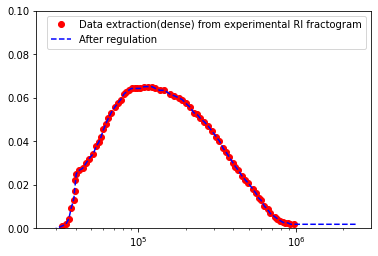

In [20]:
from scipy import interpolate
x=o1
y=m1
fig, ax = plt.subplots()
ax.semilogx(x,y,'ro')
f=interpolate.interp1d(x,y,kind='linear',fill_value="extrapolate")
ynew=f(xnew)
plt.plot(xnew,ynew,'b--')
plt.legend(['Data extraction(dense) from experimental RI fractogram','After regulation'])
# plt.xlim([0,1e6])
plt.ylim([0,0.1])
plt.show()

In [21]:
np.sum(ynew),np.sum(m1),np.sum(m2)

(7.66003736173807, 2.659315403, 3.262102688)

In [22]:
x_conjugate = xnew
y_conjugate = ynew
def predict_verification3(Mw,baselined_intensity):
  ##Module calculation
  sigmaH = 0
  W = []
  M =[]
  H =[]
  sum_Wi_Mi = 0  
  sum_WiMi = 0   

  for x,y in zip(Mw, baselined_intensity):
    if x >= Mw.min() and x <= Mw.max():
      sigmaH += y
      M.append(x)

  for x,y in zip(Mw, baselined_intensity):
    if x >= Mw.min() and x <= Mw.max():
      W.append(y/sigmaH)
      H.append(y)

  for i in range(len(W)):
    sum_Wi_Mi += W[i]/M[i]
    sum_WiMi += W[i]*M[i]


  Mn_tot = 1/(sum_Wi_Mi)
  Mw_tot = sum_WiMi
  PDI = Mw_tot / Mn_tot

  print(f'RI(dense, after regulation)-derived Conjugate Mn is {Mn_tot:.1f} Da, Mw is {Mw_tot:.1f} Da, PDI is {PDI:.2f}')
predict_verification3(x_conjugate,y_conjugate)


RI(dense, after regulation)-derived Conjugate Mn is 115572.3 Da, Mw is 200234.4 Da, PDI is 1.73


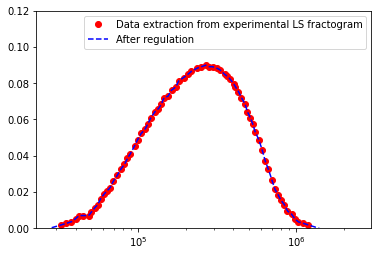

In [23]:
from scipy import interpolate
x=o2
y=m2
fig, ax = plt.subplots()
ax.semilogx(x,y,'ro')
f=interpolate.interp1d(x,y,kind='linear',fill_value="extrapolate")
ynew1=f(xnew)
plt.plot(xnew,ynew1,'b--')
plt.legend(['Data extraction from experimental LS fractogram','After regulation'])
# plt.xlim([0,1e6])
plt.ylim([0,0.12])
plt.show()

In [24]:
x_conjugate = xnew
y_conjugate = ynew1
def predict_verification3(Mw,baselined_intensity):
  ##Module calculation
  sigmaH = 0
  W = []
  M =[]
  H =[]
  sum_Wi_Mi = 0  
  sum_WiMi = 0   

  for x,y in zip(Mw, baselined_intensity):
    if x >= Mw.min() and x <= Mw.max():
      sigmaH += y/x
      M.append(x)

  for x,y in zip(Mw, baselined_intensity):
    if x >= Mw.min() and x <= Mw.max():
      W.append(y/x/sigmaH)
      H.append(y)

  for i in range(len(W)):
    sum_Wi_Mi += W[i]/M[i]
    sum_WiMi += W[i]*M[i]


  Mn_tot = 1/(sum_Wi_Mi)
  Mw_tot = sum_WiMi
  PDI = Mw_tot / Mn_tot

  print(f'LS(dense,after regulation)-derived Conjugate Mn is {Mn_tot:.1f} Da, Mw is {Mw_tot:.1f} Da, PDI is {PDI:.2f}')
predict_verification3(x_conjugate,y_conjugate)


LS(dense,after regulation)-derived Conjugate Mn is 112787.0 Da, Mw is 176426.2 Da, PDI is 1.56


In [25]:
np.min(ynew1/xnew/ynew),np.max(ynew1/xnew/ynew)
xx = ynew1/xnew/ynew
yy=xx[50:210]
zz=xx[110:150]

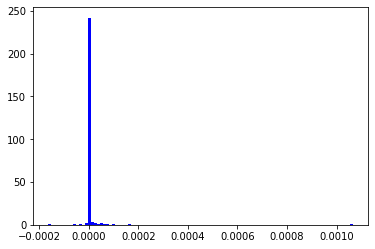

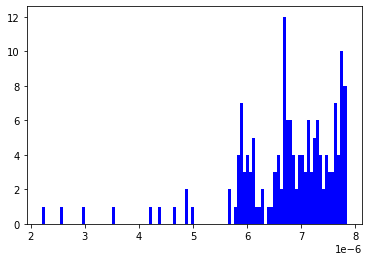

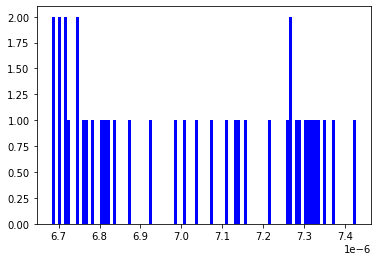

In [26]:
num_bins1, num_bins2 = 100, 100
# the histogram of the data  
n, bins, patches = plt.hist(xx, num_bins1,facecolor='blue')  
plt.show()
n, bins, patches = plt.hist(yy, num_bins2,facecolor='blue')  
plt.show()
n, bins, patches = plt.hist(zz, num_bins2,facecolor='blue')  

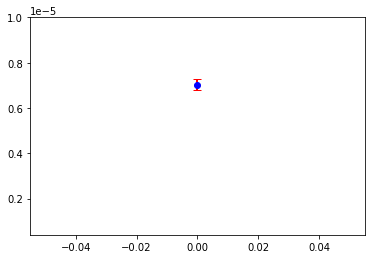

In [27]:
plt.errorbar(0,np.mean(zz),yerr= np.std(zz),fmt='o',ecolor='r',color='b',elinewidth=2,capsize=4)
plt.ylim([0.4e-6,10e-6])
plt.show()

In [28]:
x_conjugate = o1
y_conjugate = m1
def predict_verification3(Mw,baselined_intensity):
  ##Module calculation
  sigmaH = 0
  W = []
  M =[]
  H =[]
  sum_Wi_Mi = 0  
  sum_WiMi = 0   

  for x,y in zip(Mw, baselined_intensity):
    if x >= Mw.min() and x <= Mw.max():
      sigmaH += y
      M.append(x)

  for x,y in zip(Mw, baselined_intensity):
    if x >= Mw.min() and x <= Mw.max():
      W.append(y/sigmaH)
      H.append(y)

  for i in range(len(W)):
    sum_Wi_Mi += W[i]/M[i]
    sum_WiMi += W[i]*M[i]


  Mn_tot = 1/(sum_Wi_Mi)
  Mw_tot = sum_WiMi
  PDI = Mw_tot / Mn_tot

  print(f'RI(dense)-derived Conjugate Mn is {Mn_tot:.1f} Da, Mw is {Mw_tot:.1f} Da, PDI is {PDI:.2f}')
predict_verification3(x_conjugate,y_conjugate)

RI(dense)-derived Conjugate Mn is 105125.4 Da, Mw is 177977.6 Da, PDI is 1.69


In [29]:
x_conjugate = o2
y_conjugate = m2
def predict_verification3(Mw,baselined_intensity):
  ##Module calculation
  sigmaH = 0
  W = []
  M =[]
  H =[]
  sum_Wi_Mi = 0  
  sum_WiMi = 0   

  for x,y in zip(Mw, baselined_intensity):
    if x >= Mw.min() and x <= Mw.max():
      sigmaH += y/x#NOTICE!!LS signal is porpotional to the product of conc and M
      M.append(x)

  for x,y in zip(Mw, baselined_intensity):
    if x >= Mw.min() and x <= Mw.max():
      W.append(y/x/sigmaH)
      H.append(y)

  for i in range(len(W)):
    sum_Wi_Mi += W[i]/M[i]
    sum_WiMi += W[i]*M[i]


  Mn_tot = 1/(sum_Wi_Mi)
  Mw_tot = sum_WiMi
  PDI = Mw_tot / Mn_tot

  print(f'LS(dense)-derived Conjugate Mn is {Mn_tot:.1f} Da, Mw is {Mw_tot:.1f} Da, PDI is {PDI:.2f}')
predict_verification3(x_conjugate,y_conjugate)


LS(dense)-derived Conjugate Mn is 114277.2 Da, Mw is 182247.3 Da, PDI is 1.59


Text(0.5, 1.0, 'L-3 comparison between experimental(coarse) and prediction results')

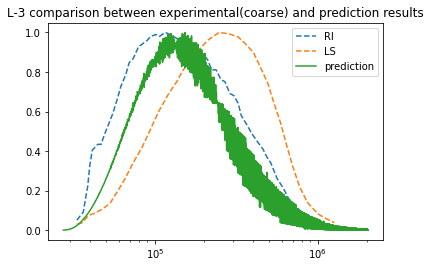

In [30]:
with open('/content/drive/MyDrive/Master Research/GPC Calculation Model/data/All data/L-3 MALS-RI(coarse).csv', encoding="utf-8") as f:
    #pass
    data2 = np.loadtxt(f, delimiter = ",")
    m1 = data2[:, 1]
    o1 = data2[:, 2]
with open('/content/drive/MyDrive/Master Research/GPC Calculation Model/data/All data/L-3 MALS-LS(coarse).csv', encoding="utf-8") as f:
    #pass
    data2 = np.loadtxt(f, delimiter = ",")
    m2 = data2[:, 1]
    o2 = data2[:, 2]
 
fig, ax = plt.subplots()
ax.semilogx(o1,m1/np.max(m1),'--')
plt.semilogx(o2,m2/np.max(m2),'--')
plt.semilogx(n2,p2/np.max(p2),'-')
plt.legend(['RI','LS','prediction'])
plt.title('L-3 comparison between experimental(coarse) and prediction results')

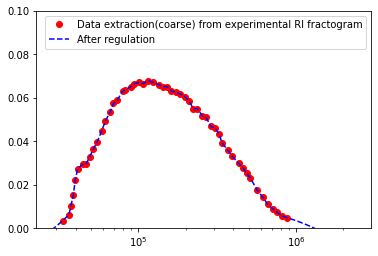

In [31]:
from scipy import interpolate
x=o1
y=m1
fig, ax = plt.subplots()
ax.semilogx(x,y,'ro')
f=interpolate.interp1d(x,y,kind='linear',fill_value="extrapolate")
ynew=f(xnew)
plt.plot(xnew,ynew,'b--')
plt.legend(['Data extraction(coarse) from experimental RI fractogram','After regulation'])
# plt.xlim([0,1e6])
plt.ylim([0,0.1])
plt.show()

In [32]:
x_conjugate = xnew
y_conjugate = ynew
def predict_verification3(Mw,baselined_intensity):
  ##Module calculation
  sigmaH = 0
  W = []
  M =[]
  H =[]
  sum_Wi_Mi = 0  
  sum_WiMi = 0   

  for x,y in zip(Mw, baselined_intensity):
    if x >= Mw.min() and x <= Mw.max():
      sigmaH += y
      M.append(x)

  for x,y in zip(Mw, baselined_intensity):
    if x >= Mw.min() and x <= Mw.max():
      W.append(y/sigmaH)
      H.append(y)

  for i in range(len(W)):
    sum_Wi_Mi += W[i]/M[i]
    sum_WiMi += W[i]*M[i]


  Mn_tot = 1/(sum_Wi_Mi)
  Mw_tot = sum_WiMi
  PDI = Mw_tot / Mn_tot

  print(f'RI(coarse, after regulation)-derived Conjugate Mn is {Mn_tot:.1f} Da, Mw is {Mw_tot:.1f} Da, PDI is {PDI:.2f}')
predict_verification3(x_conjugate,y_conjugate)


RI(coarse, after regulation)-derived Conjugate Mn is 112652.9 Da, Mw is 147208.0 Da, PDI is 1.31


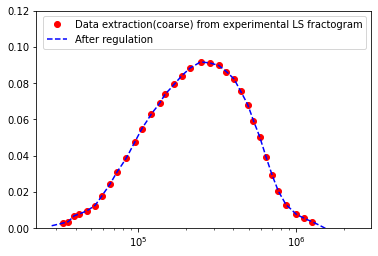

In [33]:
from scipy import interpolate
x=o2
y=m2
fig, ax = plt.subplots()
ax.semilogx(x,y,'ro')
f=interpolate.interp1d(x,y,kind='linear',fill_value="extrapolate")
ynew1=f(xnew)
plt.plot(xnew,ynew1,'b--')
plt.legend(['Data extraction(coarse) from experimental LS fractogram','After regulation'])
# plt.xlim([0,1e6])
plt.ylim([0,0.12])
plt.show()

In [34]:
x_conjugate = xnew
y_conjugate = ynew1
def predict_verification3(Mw,baselined_intensity):
  ##Module calculation
  sigmaH = 0
  W = []
  M =[]
  H =[]
  sum_Wi_Mi = 0  
  sum_WiMi = 0   

  for x,y in zip(Mw, baselined_intensity):
    if x >= Mw.min() and x <= Mw.max():
      sigmaH += y/x
      M.append(x)

  for x,y in zip(Mw, baselined_intensity):
    if x >= Mw.min() and x <= Mw.max():
      W.append(y/x/sigmaH)
      H.append(y)

  for i in range(len(W)):
    sum_Wi_Mi += W[i]/M[i]
    sum_WiMi += W[i]*M[i]


  Mn_tot = 1/(sum_Wi_Mi)
  Mw_tot = sum_WiMi
  PDI = Mw_tot / Mn_tot

  print(f'LS(coarse, after regulation)-derived Conjugate Mn is {Mn_tot:.1f} Da, Mw is {Mw_tot:.1f} Da, PDI is {PDI:.2f}')
predict_verification3(x_conjugate,y_conjugate)

LS(coarse, after regulation)-derived Conjugate Mn is 108185.6 Da, Mw is 174737.7 Da, PDI is 1.62


In [35]:
x_conjugate = o1
y_conjugate = m1
def predict_verification3(Mw,baselined_intensity):
  ##Module calculation
  sigmaH = 0
  W = []
  M =[]
  H =[]
  sum_Wi_Mi = 0  
  sum_WiMi = 0   

  for x,y in zip(Mw, baselined_intensity):
    if x >= Mw.min() and x <= Mw.max():
      sigmaH += y
      M.append(x)

  for x,y in zip(Mw, baselined_intensity):
    if x >= Mw.min() and x <= Mw.max():
      W.append(y/sigmaH)
      H.append(y)

  for i in range(len(W)):
    sum_Wi_Mi += W[i]/M[i]
    sum_WiMi += W[i]*M[i]


  Mn_tot = 1/(sum_Wi_Mi)
  Mw_tot = sum_WiMi
  PDI = Mw_tot / Mn_tot

  print(f'RI(coarse)-derived Conjugate Mn is {Mn_tot:.1f} Da, Mw is {Mw_tot:.1f} Da, PDI is {PDI:.2f}')
predict_verification3(x_conjugate,y_conjugate)


RI(coarse)-derived Conjugate Mn is 109300.4 Da, Mw is 181960.2 Da, PDI is 1.66


In [36]:
x_conjugate = o2
y_conjugate = m2
def predict_verification3(Mw,baselined_intensity):
  ##Module calculation
  sigmaH = 0
  W = []
  M =[]
  H =[]
  sum_Wi_Mi = 0  
  sum_WiMi = 0   

  for x,y in zip(Mw, baselined_intensity):
    if x >= Mw.min() and x <= Mw.max():
      sigmaH += y/x
      M.append(x)

  for x,y in zip(Mw, baselined_intensity):
    if x >= Mw.min() and x <= Mw.max():
      W.append(y/x/sigmaH)
      H.append(y)

  for i in range(len(W)):
    sum_Wi_Mi += W[i]/M[i]
    sum_WiMi += W[i]*M[i]


  Mn_tot = 1/(sum_Wi_Mi)
  Mw_tot = sum_WiMi
  PDI = Mw_tot / Mn_tot

  print(f'LS(coarse)-derived Conjugate Mn is {Mn_tot:.1f} Da, Mw is {Mw_tot:.1f} Da, PDI is {PDI:.2f}')
predict_verification3(x_conjugate,y_conjugate)


LS(coarse)-derived Conjugate Mn is 106859.7 Da, Mw is 179969.9 Da, PDI is 1.68


In [37]:
np.sum(ynew1)

10.004295642132927